## (6) In this exercise, you will further analyze the Wage data set considered throughout this chapter.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import f_regression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

%matplotlib inline

wage=pd.read_csv("https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Wage.csv")
wage.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


### (a) Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal degree `d ` for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial ft to the data.

In [4]:
np.random.seed(5)

In [5]:
# Model variables
y = wage['wage']  # Assuming 'data' contains both 'age' and 'wage'
X = wage[['age']]  # Use double brackets to keep X as DataFrame

# Compute regression models with different degrees
# Variable 'scores' saves mean squared errors resulting from the different degrees models.
# Cross-validation is used
scores = []  
for i in range(11):  # range(11) will iterate from 0 to 10
    model = Pipeline([('poly', PolynomialFeatures(degree=i)), ('linear', LinearRegression())])
    model.fit(X, y)

    score = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')  # Negative sign to make it positive
    scores.append(np.mean(score))

scores = np.array(scores)  # Convert scores to numpy array for better handling

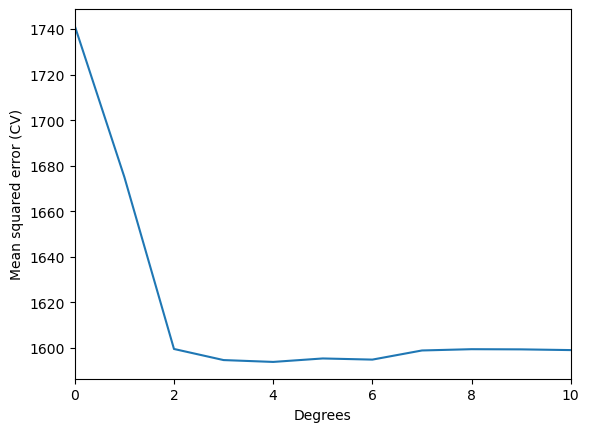

In [6]:
# Plot errors
x_plot = np.arange(0,11)

plt.plot(x_plot, scores)
plt.ylabel('Mean squared error (CV)')
plt.xlabel('Degrees')
plt.xlim(0,10)
plt.show()

In [7]:
# Print array element correspoding to the minimum mean squared error
# Element number = polynomial degree for minimum mean squared error
print(np.where(scores == np.min(scores)))

(array([4], dtype=int64),)


Optimal degree `d` for the polynomial according to cross-validation: __4__

We will use `statsmodels` to perform the hypothesis testing using ANOVA. Statsmodels has a built-in function that simplifies our job and we didn't find an equivalent way of solving the problem with `scikit-learn`.

In [8]:
# Fit polynomial models to use in statsmodels.
models=[]
for i in range(0,11):
    poly = PolynomialFeatures(degree=i)
    X_pol = poly.fit_transform(X)
    model = sm.GLS(y, X_pol).fit()
    models.append(model)

In [9]:
# Hypothesis testing using ANOVA
sm.stats.anova_lm(models[0], models[1], models[2], models[3], models[4], models[5], models[6], typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2999.0,5.222086e+06,0.0,NaN,NaN,NaN
1,2998.0,5.022216e+06,1.0,199869.664970,125.505882,1.444930e-28
2,2997.0,4.793430e+06,1.0,228786.010128,143.663571,2.285169e-32
3,2996.0,4.777674e+06,1.0,15755.693664,9.893609,1.674794e-03
4,2995.0,4.771604e+06,1.0,6070.152124,3.811683,5.098933e-02
5,2994.0,4.770322e+06,1.0,1282.563017,0.805371,3.695646e-01
6,2993.0,4.766389e+06,1.0,3932.257629,2.469216,1.162015e-01


The lower the values of *F*, the lower the significance of the coefficient. Degrees higher than 4 don't improve the polynomial regression model significantly. This results is __in agreement with cross validation results.__

In [10]:
# Save optimal degree
opt_degree = 4

C:\Users\uky994\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


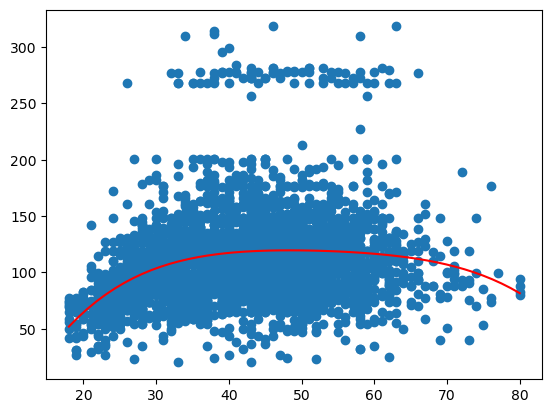

In [11]:
# Plot polynomial regression
# Auxiliary variables X_line and y_line are created.
# These variables allow us to draw the polynomial regression.
# np.linspace() is used to create an ordered sequence of numbers. Then we can plot the polynomial regression.
model = Pipeline([('poly', PolynomialFeatures(degree = opt_degree)), ('linear', LinearRegression())])
model.fit(X,y)

X_lin = np.linspace(18,80)[:,np.newaxis]
y_lin = model.predict(X_lin)

plt.scatter(X,y)
plt.plot(X_lin, y_lin,'-r');

### (b) Fit a step function to predict wage using age, and perform crossvalidation to choose the optimal number of cuts. Make a plot of the fit obtained.

In [12]:
# Compute cross-validated errors of step function
'''
To define the step function, we need to cut the dataset into parts (pd.cut() does the job)
and associate a each part to a dummy variable. For example, if we have two parts (age<50
and age >= 50), we will have one dummy variable that gets value 1 if age<50 and value 0
if age>50.

Once we have the dataset in these conditions, we need to fit a linear regression to it.
The governing model will be defined by: y = b0 + b1 C1 + b2 C2 + ... + bn Cn, where
  b stands for the regression coefficient;
  C stands for the value of a dummy variable.

Using the same example as above, we have y = b0 + b1 C1, thus ...
'''
scores = []
for i in range(1,10):
    age_groups = pd.cut(wage['age'], i)
    df_dummies = pd.get_dummies(age_groups)

    X_cv = df_dummies
    y_cv = wage['wage']

    model.fit(X_cv, y_cv)
    score = cross_val_score(model, X_cv, y_cv, cv=5, scoring='neg_mean_squared_error')
    scores.append(score)

scores = np.abs(scores)  # Scikit computes negative mean square errors, so we need to turn the values positive.

In [13]:
# Number of cuts that minimize the error
min_scores = []
for i in range(0,9):
    min_score = np.mean(scores[i,:])
    min_scores.append(min_score)

    print('Number of cuts: %i, error %.3f' % (i+1, min_score))

Number of cuts: 1, error 1741.335
Number of cuts: 2, error 1733.274
Number of cuts: 3, error 1686.385
Number of cuts: 4, error 1635.115
Number of cuts: 5, error 1636.115
Number of cuts: 6, error 1624.685
Number of cuts: 7, error 1615.042
Number of cuts: 8, error 1601.848
Number of cuts: 9, error 1614.425


The number of cuts that minimize the error is __8.__

In [14]:
# Plot
# The following code shows, step by step, how to plot the step function.

# Convert ages to groups of age ranges
n_groups = 8
age_groups = pd.cut(wage['age'], n_groups)

# Dummy variables
# Dummy variables is a way to deal with categorical variables in linear regressions.
# It associates the value 1 to the group to which the variable belongs, and the value 0 to the remaining groups.
# For example, if age == 20, the (18,25] will have the value 1 while the group (25, 32] will have the value 0.
age_dummies = pd.get_dummies(age_groups)

# Dataset for step function
# Add wage to the dummy dataset.
df_step = age_dummies.join(wage['wage'])

df_step.head()  # Just to visualize the dataset with the specified number of cuts

,"(17.938, 25.75]","(25.75, 33.5]","(33.5, 41.25]","(41.25, 49.0]","(49.0, 56.75]","(56.75, 64.5]","(64.5, 72.25]","(72.25, 80.0]",wage
0,True,False,False,False,False,False,False,False,75.043154
1,True,False,False,False,False,False,False,False,70.476020
2,False,False,False,True,False,False,False,False,130.982177
3,False,False,False,True,False,False,False,False,154.685293
4,False,False,False,False,True,False,False,False,75.043154


In [15]:
# Variables to fit the step function
# X == dummy variables; y == wage.
X_step = df_step.iloc[:,:-1]
y_step = df_step.iloc[:,-1]

In [16]:
# Fit step function (statsmodels)
reg = sm.GLM(y_step, X_step).fit()

In [17]:
# Auxiliary data to plot the step function
# We need to create a comprehensive set of ordered points to draw the figure.
# These points are based on 'age' values but include also the dummy variables identifiying the group that 'age' belongs.
X_aux = np.linspace(18,80)
groups_aux = pd.cut(X_aux, n_groups)
aux_dummies = pd.get_dummies(groups_aux)

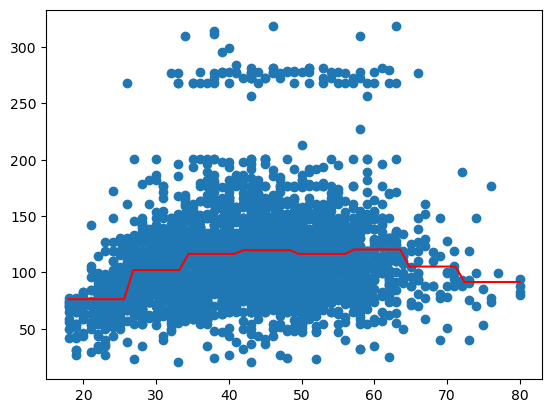

In [18]:
# Plot step function
X_step_lin = np.linspace(18,80)
y_lin = reg.predict(aux_dummies)

plt.scatter(X,y)
plt.plot(X_step_lin, y_lin,'-r');

## 10. This question relates to the [College data set](https://www.statlearning.com/s/College.csv).

In [19]:
df = pd.read_csv('https://www.statlearning.com/s/College.csv', index_col=0)

# Dummy variables
# The feature 'Private' is categorical. In order to use it in our models, we need to use dummy variables.
df = pd.get_dummies(df)
df.head()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private_No,Private_Yes
Abilene Christian University,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,False,True
Adelphi University,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,False,True
Adrian College,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,False,True
Agnes Scott College,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,False,True
Alaska Pacific University,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,False,True


### (a) Split the data into a training set and a test set. Using out-of-state tuition as the response and the other variables as the predictors, perform forward stepwise selection on the training set in order to identify a satisfactory model that uses just a subset of the predictors.

In [23]:
# Dataset
X = df.drop(['Outstate'], axis=1)
y = df['Outstate']

# Split into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)

C:\Users\uky994\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\uky994\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


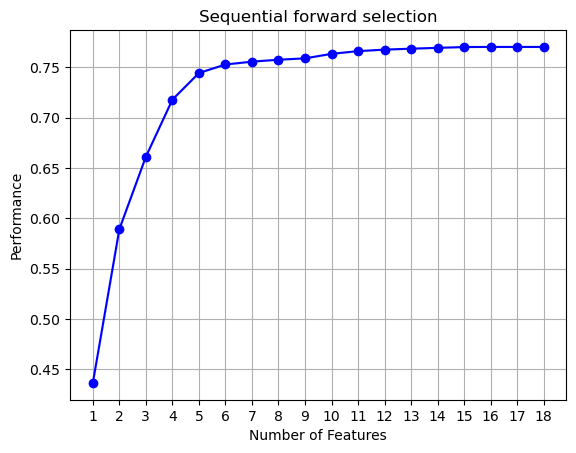

In [24]:
# Forward stepwise selection
lr = LinearRegression()

sfs = SFS(lr,
          k_features = 18,  # We have 18 features
          forward = True,
          floating = False,
          scoring = 'r2',
          cv = 0)

sfs = sfs.fit(X_train, y_train)  # as_matrix() to be readable by sfs

fig = plot_sfs(sfs.get_metric_dict())

#plt.title('Sequential forward selection (w. StdDev)')
plt.title('Sequential forward selection')
plt.grid()
plt.show()

We will choose _6 features._ The figure shows that a larger number of features will not increase the performance significantly.

In [25]:
# Visualizing the results in dataframes
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(7,)",[0.4362198079356785],0.43622,"(Room.Board,)",NaN,0.0,NaN
2,"(7, 13)",[0.5892065138987024],0.589207,"(Room.Board, perc.alumni)",NaN,0.0,NaN
3,"(7, 13, 14)",[0.66124161844549],0.661242,"(Room.Board, perc.alumni, Expend)",NaN,0.0,NaN
4,"(7, 13, 14, 16)",[0.7180472594803899],0.718047,"(Room.Board, perc.alumni, Expend, Private_No)",NaN,0.0,NaN
5,"(7, 10, 13, 14, 16)",[0.7445389170091502],0.744539,"(Room.Board, PhD, perc.alumni, Expend, Private...",NaN,0.0,NaN
6,"(7, 10, 13, 14, 15, 16)",[0.7529797180569529],0.75298,"(Room.Board, PhD, perc.alumni, Expend, Grad.Ra...",NaN,0.0,NaN
7,"(7, 9, 10, 13, 14, 15, 16)",[0.7558186916454233],0.755819,"(Room.Board, Personal, PhD, perc.alumni, Expen...",NaN,0.0,NaN
8,"(4, 7, 9, 10, 13, 14, 15, 16)",[0.7577507694491248],0.757751,"(Top25perc, Room.Board, Personal, PhD, perc.al...",NaN,0.0,NaN
9,"(1, 4, 7, 9, 10, 13, 14, 15, 16)",[0.7590884961181228],0.759088,"(Accept, Top25perc, Room.Board, Personal, PhD,...",NaN,0.0,NaN
10,"(0, 1, 4, 7, 9, 10, 13, 14, 15, 16)",[0.7635928325779913],0.763593,"(Apps, Accept, Top25perc, Room.Board, Personal...",NaN,0.0,NaN


In [26]:
# Variables that we will choose
print('Variables: %s, %s, %s, %s, %s, %s' % (X.columns[16], X.columns[7], X.columns[10], X.columns[13], X.columns[14], X.columns[15]))

Variables: Private_No, Room.Board, PhD, perc.alumni, Expend, Grad.Rate


In [74]:
selected_features = ["Private_No", "Room.Board", "PhD", "perc.alumni", "Expend", "Grad.Rate"]
selected_features

['Private_No', 'Room.Board', 'PhD', 'perc.alumni', 'Expend', 'Grad.Rate']

### (b) Fit a GAM on the training data, using out-of-state tuition as the response and the features selected in the previous step as the predictors. Plot the results, and explain your findings.

In pyGAM, you can either use `.fit()` or `.gridsearch()` to fit GAMs on the training set. The difference is that `.gridsearch()` performs a grid search over a space of all tunable parameters; see [API](https://pygam.readthedocs.io/en/latest/api/gam.html). Thus, `.gridsearch()` is slow but may have better results.

In [75]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

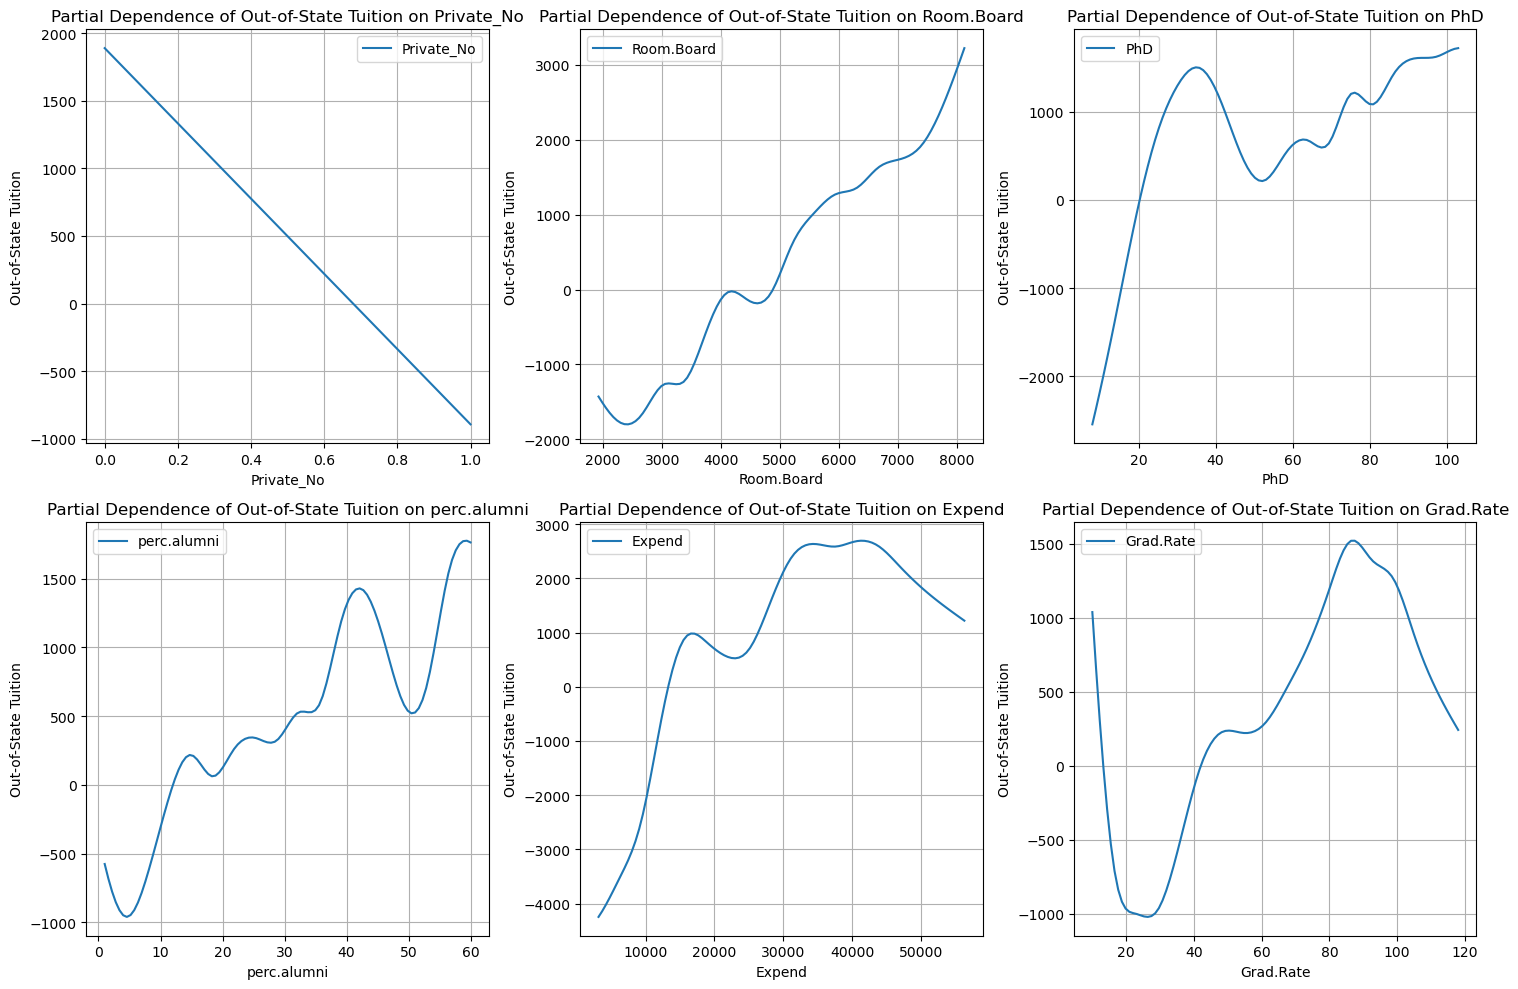

In [80]:
from pygam import LinearGAM, s, f, l

# Fit GAM model
gam = LinearGAM().fit(X_train_selected, y_train)

plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features):
    plt.subplot(2, 3, i + 1)
    XX = gam.generate_X_grid(term=i)
    partial_dep = gam.partial_dependence(term=i, X=XX)
    plt.plot(XX[:, i], partial_dep, label=feature)
    plt.title("Partial Dependence of Out-of-State Tuition on {}".format(feature))
    plt.xlabel(feature)
    plt.ylabel("Out-of-State Tuition")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [78]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     53.5653
Link Function:                     IdentityLink Log Likelihood:                                 -8679.2047
Number of Samples:                          543 AIC:                                            17467.5399
                                                AICc:                                           17479.9803
                                                GCV:                                          4232277.0771
                                                Scale:                                        3488086.0916
                                                Pseudo R-Squared:                                   0.8034
Feature Function                  Lam

C:\Users\uky994\AppData\Local\Temp\ipykernel_16204\3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In this code:

 - We select the features from the dataset based on the results of forward stepwise selection.
 - We fit a Generalized Additive Model (GAM) using the LinearGAM class from PyGAM.
 - We plot the partial dependence plots for each selected feature using the partial_dependence method of the GAM model.

### (c) Evaluate the model obtained on the test set, and explain the results obtained.

In [77]:
# Evaluate the model on the test set
test_score = gam.score(X_test_selected, y_test)
print("Test Set R^2 Score:", test_score)

Test Set R^2 Score: 0.7896781388844218


### (d) For which variables, if any, is there evidence of a non-linear relationship with the response?

We can inspect the partial dependence plots from Part (b). If the curves are non-linear, it suggests a non-linear relationship between the predictor and the response.